# Top panel: Decoding accuracy comparison (per bird)

In [8]:
# common
import os
import sys
import json
import pickle as pkl
import numpy as np
import warnings
import pandas as pd
from matplotlib import pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
from scipy.ndimage import gaussian_filter, gaussian_filter1d

def add_to_sys_path(root_dir):
    for dirpath, dirnames, filenames in os.walk(root_dir):
        sys.path.append(dirpath)        
root_dir = '/home/jovyan/pablo_tostado/bird_song/enSongDec/'
add_to_sys_path(root_dir)

# sklearn
from sklearn.metrics import mean_squared_error

# torch
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

# ensongdec
from FFNNmodel import FeedforwardNeuralNetwork, ffnn_predict
from neural_audio_dataset import NeuralAudioDataset
import utils.audio_utils as au
import utils.signal_utils as su
import utils.encodec_utils as eu

# songbirdcore
import songbirdcore.spikefinder.spike_analysis_helper as sh
import songbirdcore.spikefinder.filtering_helper as fh
import songbirdcore.utils.label_utils as luts
import songbirdcore.utils.plot_utils as puts
import songbirdcore.utils.audio_spectrogram_utils as auts

# EncoDec
from encodec import EncodecModel
from encodec.utils import convert_audio

# Tim S. noise reduce
import noisereduce as nr

from decoder_testing_functionality import *
from decoder_testing_functionality import get_original_reconstructed_audio
from decoder_testing_functionality import load_model_statedict, load_model_statedict_align_complimentary_space

## Reconstruct spectrogams and compute reconstruction error

spiketrains HVC
Loading model:  z_w12m7_20_RAW_hvc_all_FFNN_20240409_015347.pt
Loading z_w12m7_20_RAW_hvc_all_FFNN_20240409_015347_metadata.json
Loaded model: train_idxs:  [0, 1, 2, 3, 4, 5, 6, 7]  - test_ixs:  [8, 9]  - model_layers:  [228, 64, 64, 128]
Length of neural trials: 700.0 ms, length of audio trials: 700.0 ms. 
Using 2 bins of neural data history.
Data loaders created. Training samples: 808, Testing sample: 206
spiketrains RA
Loading model:  z_w12m7_20_RAW_ra_all_FFNN_20240409_015856.pt
Loading z_w12m7_20_RAW_ra_all_FFNN_20240409_015856_metadata.json
Loaded model: train_idxs:  [0, 1, 2, 3, 4, 5, 6, 7]  - test_ixs:  [8, 9]  - model_layers:  [344, 64, 64, 128]
Length of neural trials: 700.0 ms, length of audio trials: 700.0 ms. 
Using 2 bins of neural data history.
Data loaders created. Training samples: 808, Testing sample: 206
latent-trajectories HVC
Loading model:  z_w12m7_20_TRAJECTORIES_hvc_all_FFNN_20240409_020154.pt
Loading z_w12m7_20_TRAJECTORIES_hvc_all_FFNN_20240409

(Text(0, 0.5, ''), [])

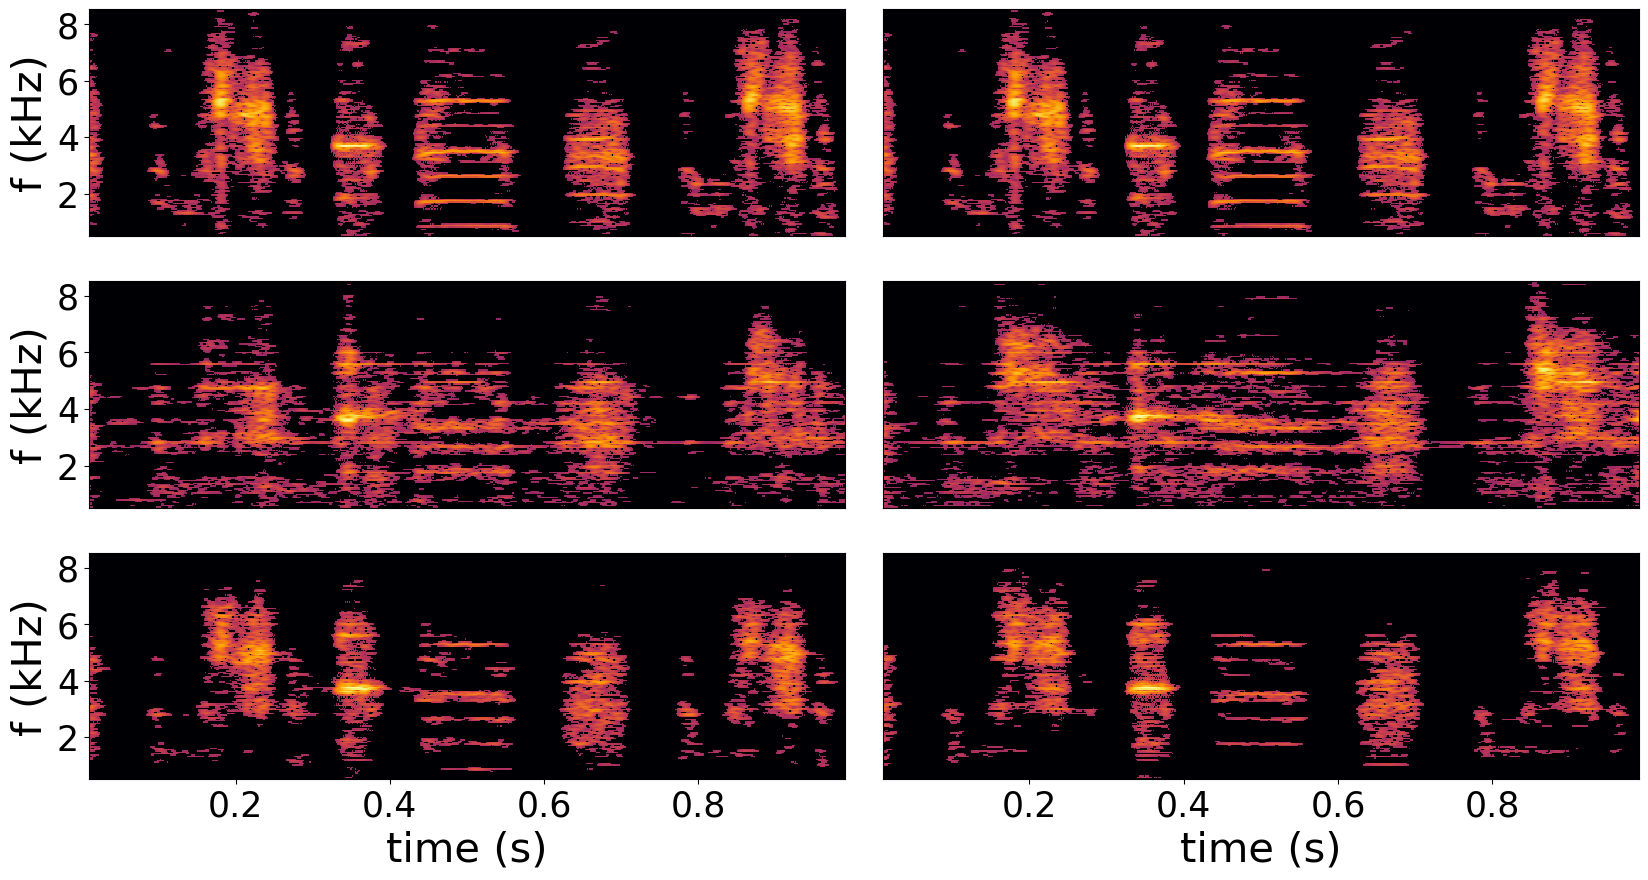

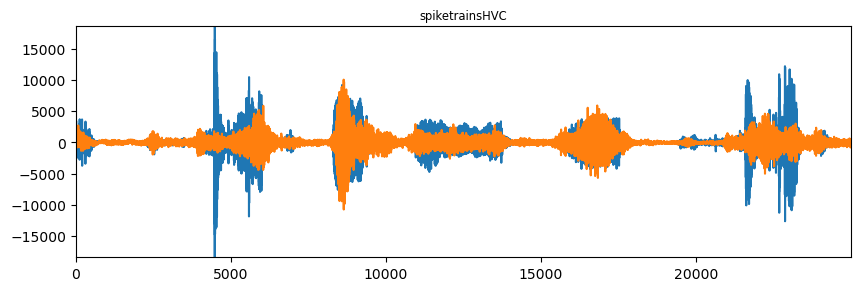

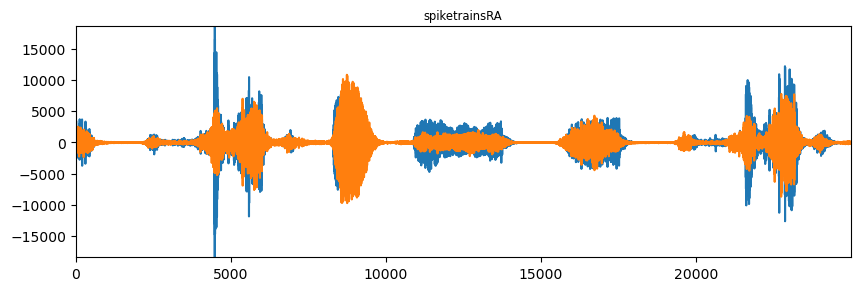

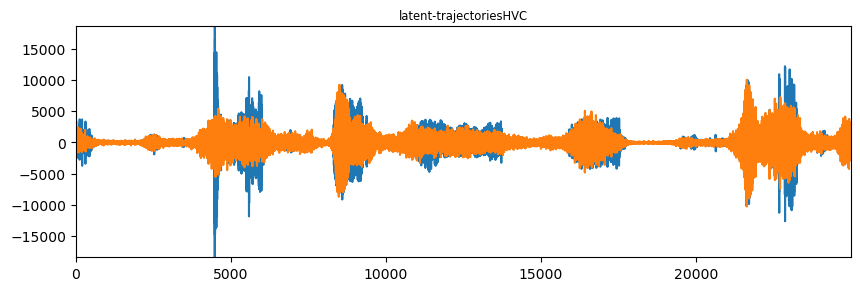

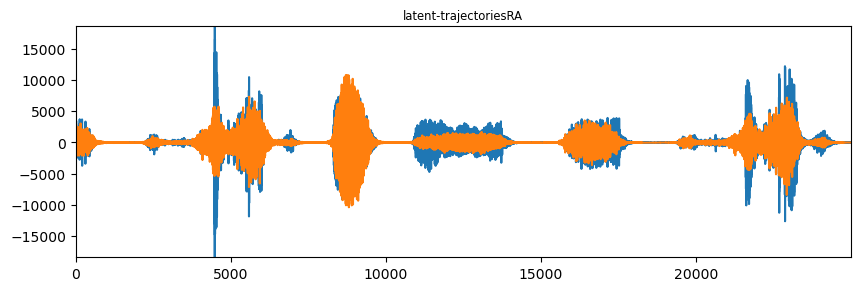

In [2]:
warnings.filterwarnings("ignore")

bird = 'z_w12m7_20'
models_dict = {
    'spiketrains': {
        'HVC': '015347',
        'RA': '015856'
    },
    
    'latent-trajectories': {
        'HVC': '020154',
        'RA': '020155'
    }
}

# Dirs
models_checkpoints_dir = '/home/jovyan/pablo_tostado/bird_song/enSongDec/ensongdec/models_checkpoints/'
dataset_dir = '/home/jovyan/pablo_tostado/bird_song/enSongDec/data/'

column_names = ['model_name', 'nucleus', 'model', 'Spectrogram reconstruction error']
decoding_accuracy_df1 = pd.DataFrame(columns=column_names)

# Plotting setup
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(20, 10))
plt.subplots_adjust(wspace=0.05)

# Processing each model type and nucleus
for col, model_type in enumerate(models_dict):
    for row, nucleus in enumerate(models_dict[model_type]):
        print(model_type, nucleus)

        # Load model
        model_timestamp = models_dict[model_type][nucleus]
        model_extension = '.pt'  
        model_files = [file for file in os.listdir(models_checkpoints_dir) if file.endswith(model_extension)]
        model_filename = next((file for file in model_files if model_timestamp in file), None)

        print('Loading model: ', model_filename)
        ffnn_model, test_dataset, test_loader, fs_audio, encodec_model, scales = load_model_statedict(models_checkpoints_dir, dataset_dir, model_filename, shuffle_inputs=False)

        # Reconstruct spectrogram
        scale = torch.mean(scales)
        original_audio, decoded_audio = get_original_reconstructed_audio(ffnn_model, test_dataset, test_loader, fs_audio, encodec_model, scale)

        # Calculate spectrogram reconstruction error
        s1 = su.normalize_signal(au.pretty_spectrogram(original_audio))
        s2 = su.normalize_signal(au.pretty_spectrogram(decoded_audio))
        spec_reconstruction_error = mean_squared_error(s1, s2, multioutput='raw_values')
        
        decoding_accuracy_df1.loc[len(decoding_accuracy_df1)] = [model_filename, nucleus, model_type, spec_reconstruction_error]

        # Plot original and reconstructed
        plot_s = 1
        plot_samples = int(plot_s*fs_audio)
        
        plt.subplots(nrows=1, figsize=(10, 3))
        plt.title(model_type + nucleus)
        plt.plot(original_audio[:plot_samples])
        plt.plot(decoded_audio[:plot_samples])
        
        xlabel = True if row == 1 else False
        plot_spectrogram(decoded_audio, fs_audio, plot_samples, ax=axes[row+1, col], xlabel=xlabel)

# Top row: repeat the plot of the original spectrograms in both columns
plot_spectrogram(original_audio, fs_audio, plot_samples, ax=axes[0, 0], xlabel=False, ylabel=True)
plot_spectrogram(original_audio, fs_audio, plot_samples, ax=axes[0, 1], xlabel=False, ylabel=False)
axes[1,1].set_ylabel(''), axes[1,1].set_yticks([])
axes[2,1].set_ylabel(''), axes[2,1].set_yticks([])



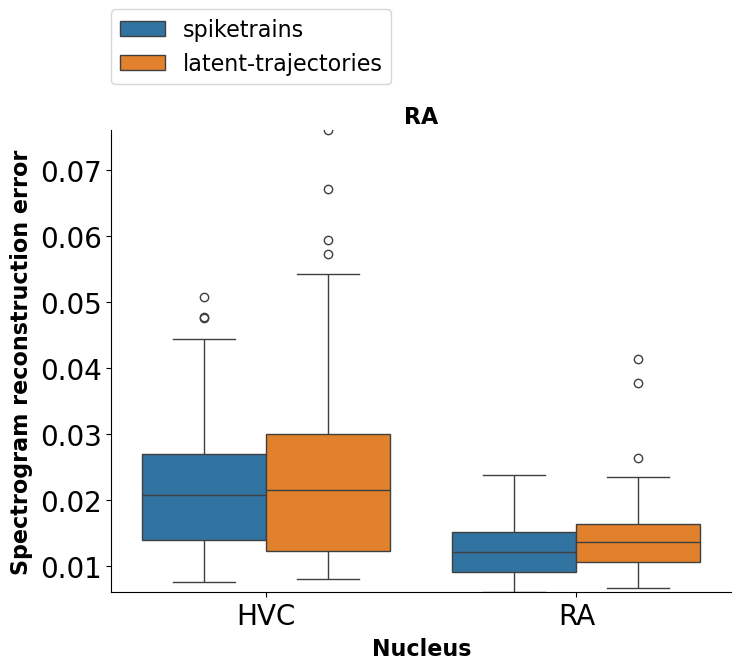

In [3]:
# Create separate rows for each value in the 'error' list
error_type = 'Spectrogram reconstruction error'
df_expanded = decoding_accuracy_df1.explode(error_type)
df_expanded[error_type] = pd.to_numeric(df_expanded[error_type])

# Create a box and whisker plot
fig, ax = plt.subplots(figsize=(8, 6))
sns.boxplot(x='nucleus', y=error_type, hue='model', data=df_expanded, notch=False)


plt.title(nucleus, fontsize=16, fontweight='bold')
plt.xlabel('Nucleus', fontsize=16, fontweight='bold')
plt.ylabel(error_type, fontsize=16, fontweight='bold')

# Remove top and right spines
# ax.set_ylim([0, 0.065])
# ax.set_xlim([-0.5, len(significance) - 0.5])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.tick_params(axis='both', which='major', labelsize=20)  # Adjust 'labelsize' as needed
plt.legend(fontsize='16', loc=(0,1.1)) 

plt.show()

spiketrains HVC
Loading model:  z_r12r13_21_RAW_hvc_all_FFNN_20240409_030450.pt
Loading z_r12r13_21_RAW_hvc_all_FFNN_20240409_030450_metadata.json
Loaded model: train_idxs:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36]  - test_ixs:  [37, 38, 39, 40, 41, 42, 43, 44, 45, 46]  - model_layers:  [150, 64, 64, 128]
Length of neural trials: 899.9666666666667 ms, length of audio trials: 899.96 ms. 
Using 3 bins of neural data history.
Data loaders created. Training samples: 4810, Testing sample: 1320
spiketrains RA
Loading model:  z_r12r13_21_RAW_ra_all_FFNN_20240409_031754.pt
Loading z_r12r13_21_RAW_ra_all_FFNN_20240409_031754_metadata.json
Loaded model: train_idxs:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36]  - test_ixs:  [37, 38, 39, 40, 41, 42, 43, 44, 45, 46]  - model_layers:  [252, 64, 64, 128]
Length

(Text(0, 0.5, ''), [])

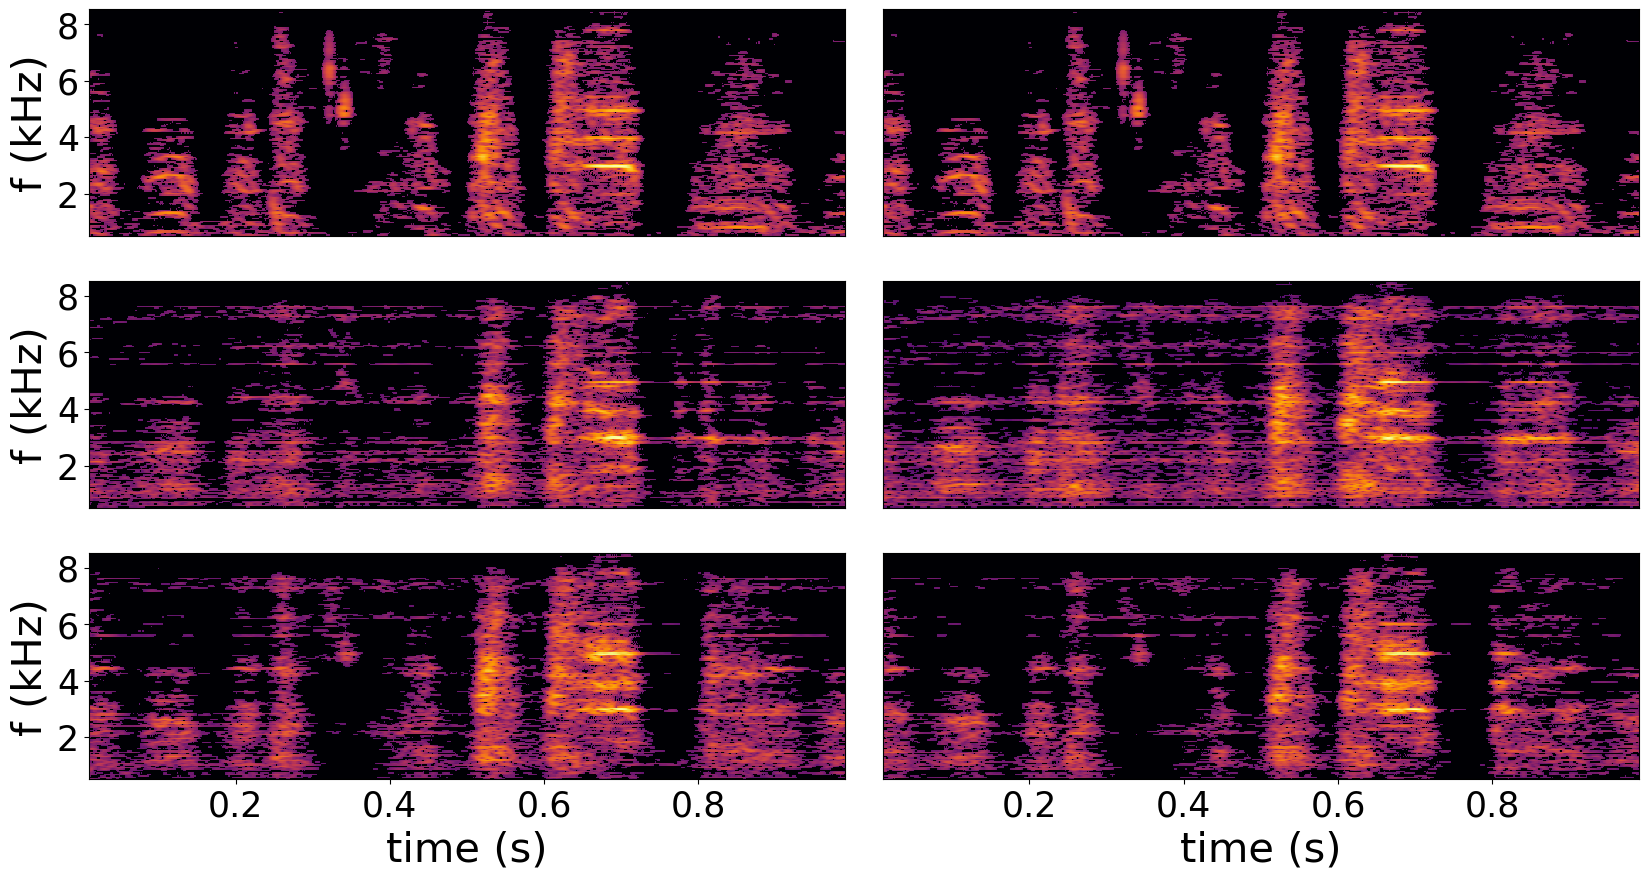

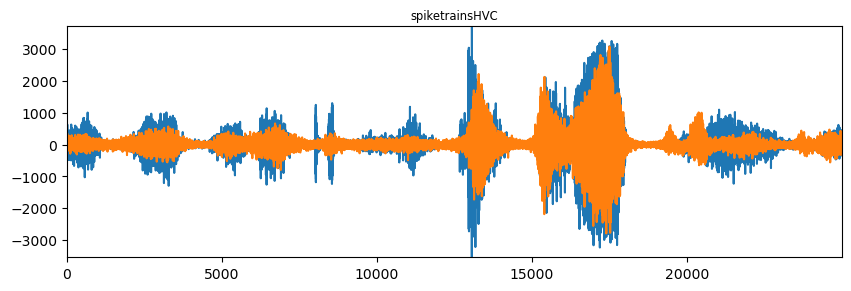

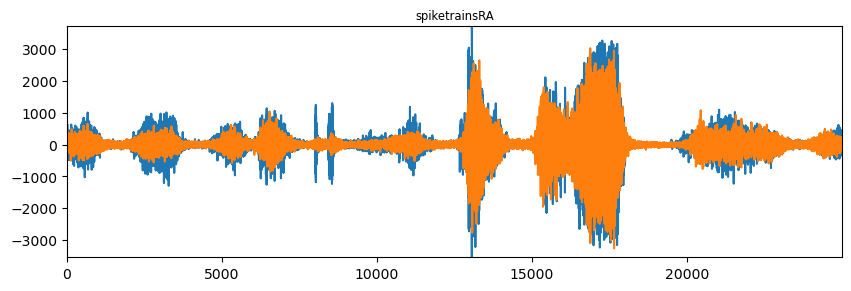

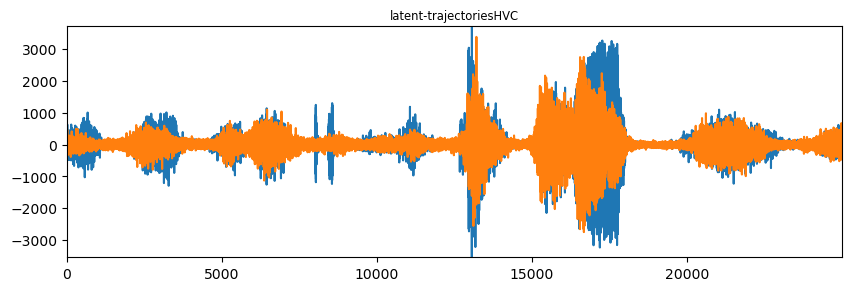

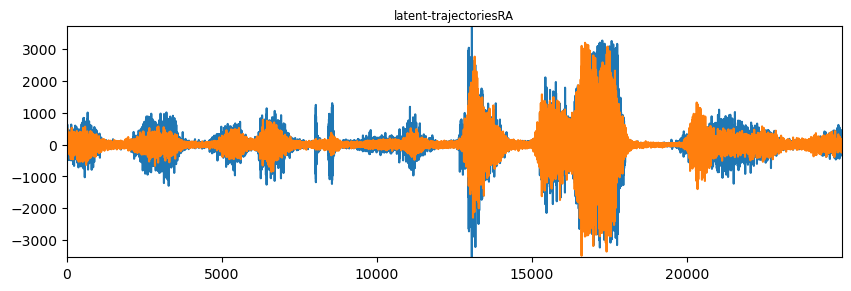

In [4]:
warnings.filterwarnings("ignore")

bird = 'z_r12r13_21'
models_dict = {
    'spiketrains': {
        'HVC': '030450',
        'RA': '031754'
    },
    
    'latent-trajectories': {
        'HVC': '031418',
        'RA': '031507'
    }
}


# Dirs
models_checkpoints_dir = '/home/jovyan/pablo_tostado/bird_song/enSongDec/ensongdec/models_checkpoints/'
dataset_dir = '/home/jovyan/pablo_tostado/bird_song/enSongDec/data/'

column_names = ['model_name', 'nucleus', 'model', 'Spectrogram reconstruction error']
decoding_accuracy_df2 = pd.DataFrame(columns=column_names)

# Plotting setup
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(20, 10))
plt.subplots_adjust(wspace=0.05)

# Processing each model type and nucleus
for col, model_type in enumerate(models_dict):
    for row, nucleus in enumerate(models_dict[model_type]):
        print(model_type, nucleus)

        # Load model
        model_timestamp = models_dict[model_type][nucleus]
        model_extension = '.pt'  
        model_files = [file for file in os.listdir(models_checkpoints_dir) if file.endswith(model_extension)]
        model_filename = next((file for file in model_files if model_timestamp in file), None)

        print('Loading model: ', model_filename)
        ffnn_model, test_dataset, test_loader, fs_audio, encodec_model, scales = load_model_statedict(models_checkpoints_dir, dataset_dir, model_filename, shuffle_inputs=False)

        # Reconstruct spectrogram
        scale = torch.mean(scales)
        original_audio, decoded_audio = get_original_reconstructed_audio(ffnn_model, test_dataset, test_loader, fs_audio, encodec_model, scale)

        # Calculate spectrogram reconstruction error
        s1 = su.normalize_signal(au.pretty_spectrogram(original_audio))
        s2 = su.normalize_signal(au.pretty_spectrogram(decoded_audio))
        spec_reconstruction_error = mean_squared_error(s1, s2, multioutput='raw_values')
        
        decoding_accuracy_df2.loc[len(decoding_accuracy_df2)] = [model_filename, nucleus, model_type, spec_reconstruction_error]

        plt.subplots(nrows=1, figsize=(10, 3))
        plt.title(model_type + nucleus)
        plt.plot(original_audio[:plot_samples])
        plt.plot(decoded_audio[:plot_samples])
        
        # Plot original and reconstructed
        plot_ms = 1
        plot_samples = int(plot_ms*fs_audio)
        
        xlabel = True if row == 1 else False
        plot_spectrogram(decoded_audio, fs_audio, plot_samples, ax=axes[row+1, col], xlabel=xlabel)

# Top row: repeat the plot of the original spectrograms in both columns
plot_spectrogram(original_audio, fs_audio, plot_samples, ax=axes[0, 0], xlabel=False, ylabel=True)
plot_spectrogram(original_audio, fs_audio, plot_samples, ax=axes[0, 1], xlabel=False, ylabel=False)
axes[1,1].set_ylabel(''), axes[1,1].set_yticks([])
axes[2,1].set_ylabel(''), axes[2,1].set_yticks([])


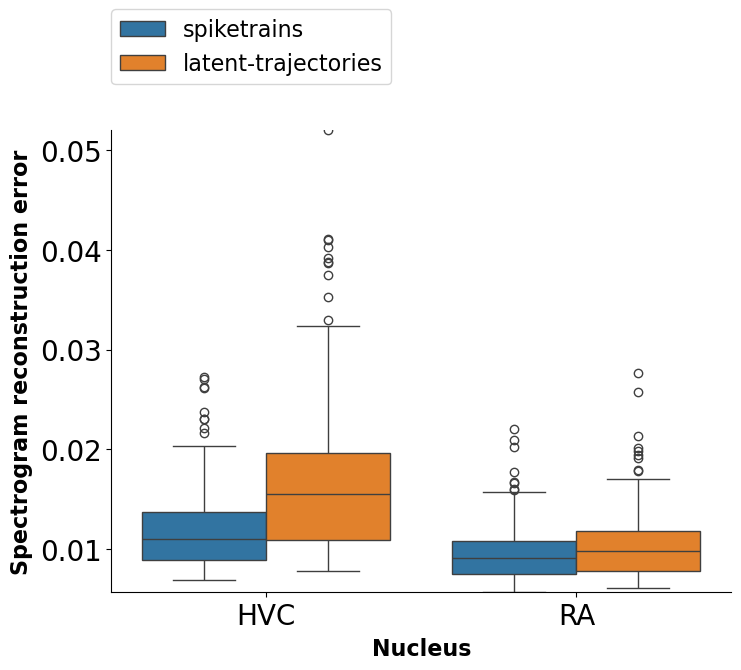

In [28]:
# Create separate rows for each value in the 'error' list
error_type = 'Spectrogram reconstruction error'
df_expanded = decoding_accuracy_df2.explode(error_type)
df_expanded[error_type] = pd.to_numeric(df_expanded[error_type])

# Create a box and whisker plot
fig, ax = plt.subplots(figsize=(8, 6))
sns.boxplot(x='nucleus', y=error_type, hue='model', data=df_expanded, notch=False)

plt.xlabel('Nucleus', fontsize=16, fontweight='bold')
plt.ylabel(error_type, fontsize=16, fontweight='bold')

# Remove top and right spines
# ax.set_ylim([0, 0.065])
# ax.set_xlim([-0.5, len(significance) - 0.5])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.tick_params(axis='both', which='major', labelsize=20)  # Adjust 'labelsize' as needed
plt.legend(fontsize='16', loc=(0,1.1)) 

plt.show()


# Generate figures with shuffle controls

In [9]:
warnings.filterwarnings("ignore")

bird = 'z_w12m7_20'
models_dict = {
    'spiketrains': {
        'HVC': '015347',
        'RA': '015856'
    },
    
    'latent-trajectories': {
        'HVC': '020154',
        'RA': '020155'
    }
}

# Dirs
models_checkpoints_dir = '/home/jovyan/pablo_tostado/bird_song/enSongDec/ensongdec/models_checkpoints/'
dataset_dir = '/home/jovyan/pablo_tostado/bird_song/enSongDec/data/'

column_names = ['model_name', 'nucleus', 'model', 'Spectrogram reconstruction error']
decoding_accuracy_df3 = pd.DataFrame(columns=column_names)


# Processing each model type and nucleus
for col, model_type in enumerate(models_dict):
    for row, nucleus in enumerate(models_dict[model_type]):
        print(model_type, nucleus)

        # Load model
        model_timestamp = models_dict[model_type][nucleus]
        model_extension = '.pt'  
        model_files = [file for file in os.listdir(models_checkpoints_dir) if file.endswith(model_extension)]
        model_filename = next((file for file in model_files if model_timestamp in file), None)

        for control in ['normal', 'control']:
            print(f'Loading model {model_filename} in {control} mode')
                            
            if control == 'control': 
                ffnn_model, test_dataset, test_loader, fs_audio, encodec_model, scales = load_model_statedict(models_checkpoints_dir, dataset_dir, model_filename, shuffle_inputs=True)
            else:
                ffnn_model, test_dataset, test_loader, fs_audio, encodec_model, scales = load_model_statedict(models_checkpoints_dir, dataset_dir, model_filename, shuffle_inputs=False)
    
            # Reconstruct spectrogram
            scale = torch.mean(scales)
            original_audio, decoded_audio = get_original_reconstructed_audio(ffnn_model, test_dataset, test_loader, fs_audio, encodec_model, scale)
    
            # Calculate spectrogram reconstruction error
            s1 = su.normalize_signal(au.pretty_spectrogram(original_audio))
            s2 = su.normalize_signal(au.pretty_spectrogram(decoded_audio))
            spec_reconstruction_error = mean_squared_error(s1, s2, multioutput='raw_values')
            
            model = model_type+'_shuffle-control' if control == 'control' else model_type
            decoding_accuracy_df3.loc[len(decoding_accuracy_df3)] = [model_filename, nucleus, model, spec_reconstruction_error]


spiketrains HVC
Loading model z_w12m7_20_RAW_hvc_all_FFNN_20240409_015347.pt in normal mode
Loading z_w12m7_20_RAW_hvc_all_FFNN_20240409_015347_metadata.json
Loaded model: train_idxs:  [0, 1, 2, 3, 4, 5, 6, 7]  - test_ixs:  [8, 9]  - model_layers:  [228, 64, 64, 128]
Length of neural trials: 700.0 ms, length of audio trials: 700.0 ms. 
Using 2 bins of neural data history.
Data loaders created. Training samples: 808, Testing sample: 206
Loading model z_w12m7_20_RAW_hvc_all_FFNN_20240409_015347.pt in control mode
Loading z_w12m7_20_RAW_hvc_all_FFNN_20240409_015347_metadata.json
Loaded model: train_idxs:  [0, 1, 2, 3, 4, 5, 6, 7]  - test_ixs:  [8, 9]  - model_layers:  [228, 64, 64, 128]
Length of neural trials: 700.0 ms, length of audio trials: 700.0 ms. 
Using 2 bins of neural data history.
CONTROL: Shuffling model inputs in the test set along the second dimension!
Data loaders created. Training samples: 808, Testing sample: 206
spiketrains RA
Loading model z_w12m7_20_RAW_ra_all_FFNN_202

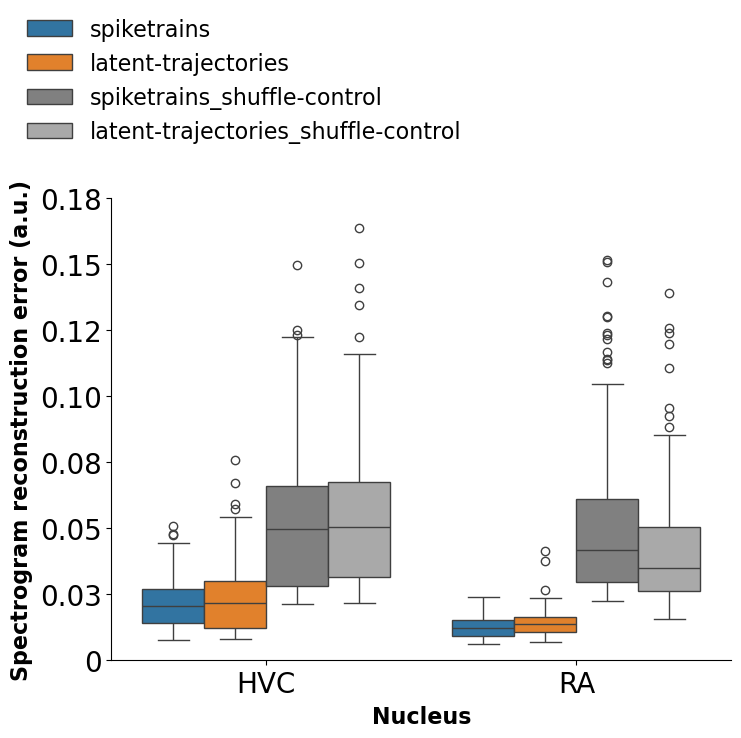

In [26]:
# Create separate rows for each value in the 'error' list
error_type = 'Spectrogram reconstruction error'
df_expanded = decoding_accuracy_df3.explode(error_type)
df_expanded[error_type] = pd.to_numeric(df_expanded[error_type])

# Define the order of the nucleus explicitly
nucleus_order = ['HVC', 'RA']  # Adjust this list based on the actual names in your dataset
hue_order = ['spiketrains', 'latent-trajectories', 'spiketrains_shuffle-control', 'latent-trajectories_shuffle-control']

# Custom color palette
colors = ['#1f77b4', '#ff7f0e', '#808080', '#A9A9A9']  # Custom colors for each model type
palette = dict(zip(hue_order, colors))

# Create a box and whisker plot
fig, ax = plt.subplots(figsize=(8, 6))
sns.boxplot(x='nucleus', y=error_type, hue='model', data=df_expanded, notch=False, palette=palette, order=nucleus_order, hue_order=hue_order)


# Title and labels
plt.xlabel('Nucleus', fontsize=16, fontweight='bold')
plt.ylabel(error_type+' (a.u.)', fontsize=16, fontweight='bold')
ax.set_ylim([0, 0.175])
# ax.set_xlim([-0.5, len(significance) - 0.5])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.tick_params(axis='both', which='major', labelsize=20)  # Adjust 'labelsize' as needed
# # Legend
plt.legend(fontsize='16', loc=(-0.15, 1.1)) 
ax.get_legend().set_frame_on(False)
# ax.get_legend().remove()

# Custom formatter for y-axis
def custom_formatter(x, pos):
    if x == 0:
        return "0"  # Return "0" if the value is zero
    else:
        return f"{x:.2f}"  # Return value with two decimal places if not zero
ax.yaxis.set_major_formatter(ticker.FuncFormatter(custom_formatter))

plt.show()


In [19]:
warnings.filterwarnings("ignore")

bird = 'z_r12r13_21'
models_dict = {
    'spiketrains': {
        'HVC': '030450',
        'RA': '031754'
    },
    
    'latent-trajectories': {
        'HVC': '031418',
        'RA': '031507'
    }
}

# Dirs
models_checkpoints_dir = '/home/jovyan/pablo_tostado/bird_song/enSongDec/ensongdec/models_checkpoints/'
dataset_dir = '/home/jovyan/pablo_tostado/bird_song/enSongDec/data/'

column_names = ['model_name', 'nucleus', 'model', 'Spectrogram reconstruction error']
decoding_accuracy_df4 = pd.DataFrame(columns=column_names)


# Processing each model type and nucleus
for col, model_type in enumerate(models_dict):
    for row, nucleus in enumerate(models_dict[model_type]):
        print(model_type, nucleus)

        # Load model
        model_timestamp = models_dict[model_type][nucleus]
        model_extension = '.pt'  
        model_files = [file for file in os.listdir(models_checkpoints_dir) if file.endswith(model_extension)]
        model_filename = next((file for file in model_files if model_timestamp in file), None)

        for control in ['normal', 'control']:
            print(f'Loading model {model_filename} in {control} mode')
                            
            if control == 'control': 
                ffnn_model, test_dataset, test_loader, fs_audio, encodec_model, scales = load_model_statedict(models_checkpoints_dir, dataset_dir, model_filename, shuffle_inputs=True)
            else:
                ffnn_model, test_dataset, test_loader, fs_audio, encodec_model, scales = load_model_statedict(models_checkpoints_dir, dataset_dir, model_filename, shuffle_inputs=False)
    
            # Reconstruct spectrogram
            scale = torch.mean(scales)
            original_audio, decoded_audio = get_original_reconstructed_audio(ffnn_model, test_dataset, test_loader, fs_audio, encodec_model, scale)
    
            # Calculate spectrogram reconstruction error
            s1 = su.normalize_signal(au.pretty_spectrogram(original_audio))
            s2 = su.normalize_signal(au.pretty_spectrogram(decoded_audio))
            spec_reconstruction_error = mean_squared_error(s1, s2, multioutput='raw_values')
            
            model = model_type+'_shuffle-control' if control == 'control' else model_type
            decoding_accuracy_df4.loc[len(decoding_accuracy_df4)] = [model_filename, nucleus, model, spec_reconstruction_error]

spiketrains HVC
Loading model z_r12r13_21_RAW_hvc_all_FFNN_20240409_030450.pt in normal mode
Loading z_r12r13_21_RAW_hvc_all_FFNN_20240409_030450_metadata.json
Loaded model: train_idxs:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36]  - test_ixs:  [37, 38, 39, 40, 41, 42, 43, 44, 45, 46]  - model_layers:  [150, 64, 64, 128]
Length of neural trials: 899.9666666666667 ms, length of audio trials: 899.96 ms. 
Using 3 bins of neural data history.
Data loaders created. Training samples: 4810, Testing sample: 1320
Loading model z_r12r13_21_RAW_hvc_all_FFNN_20240409_030450.pt in control mode
Loading z_r12r13_21_RAW_hvc_all_FFNN_20240409_030450_metadata.json
Loaded model: train_idxs:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36]  - test_ixs:  [37, 38, 39, 40, 41, 42, 43, 44, 45, 46]  - model_layers:  [150, 64, 6

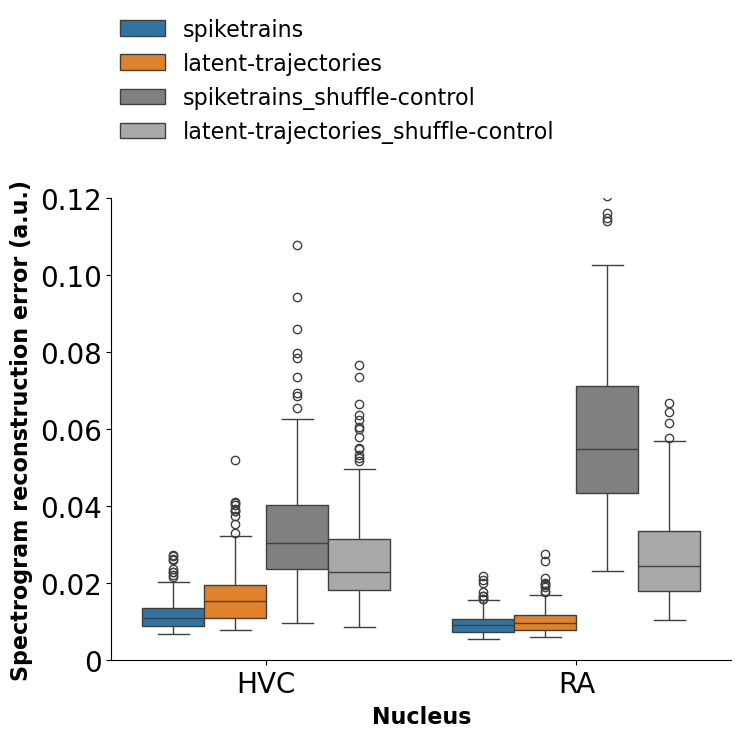

In [30]:
# Create separate rows for each value in the 'error' list
error_type = 'Spectrogram reconstruction error'
df_expanded = decoding_accuracy_df4.explode(error_type)
df_expanded[error_type] = pd.to_numeric(df_expanded[error_type])

# Define the order of the nucleus explicitly
nucleus_order = ['HVC', 'RA']  # Adjust this list based on the actual names in your dataset
hue_order = ['spiketrains', 'latent-trajectories', 'spiketrains_shuffle-control', 'latent-trajectories_shuffle-control']

# Custom color palette
colors = ['#1f77b4', '#ff7f0e', '#808080', '#A9A9A9']  # Custom colors for each model type
palette = dict(zip(hue_order, colors))

# Create a box and whisker plot
fig, ax = plt.subplots(figsize=(8, 6))
sns.boxplot(x='nucleus', y=error_type, hue='model', data=df_expanded, notch=False, palette=palette, order=nucleus_order, hue_order=hue_order)


# Title and labels
plt.xlabel('Nucleus', fontsize=16, fontweight='bold')
plt.ylabel(error_type+' (a.u.)', fontsize=16, fontweight='bold')
ax.set_ylim([0, 0.12])
# ax.set_xlim([-0.5, len(significance) - 0.5])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.tick_params(axis='both', which='major', labelsize=20)  # Adjust 'labelsize' as needed
plt.legend(fontsize='16', loc=(0,1.1)) 
ax.get_legend().set_frame_on(False)
# ax.get_legend().remove()

# Custom formatter for y-axis
def custom_formatter(x, pos):
    if x == 0:
        return "0"  # Return "0" if the value is zero
    else:
        return f"{x:.2f}"  # Return value with two decimal places if not zero
ax.yaxis.set_major_formatter(ticker.FuncFormatter(custom_formatter))

plt.show()


# Bottom panel: Stability Analysis 

spiketrains_halved_alinged HVC
Loading model:  RAW_z_w12m7_20_20240509_050826_hvc_all_latent_stability_dataset_FFNN_20240509_052938.pt
Loading RAW_z_w12m7_20_20240509_050826_hvc_all_latent_stability_dataset_FFNN_20240509_052938_metadata.json
Loaded model: train_idxs:  [0, 1, 2, 3, 4, 5, 6, 7]  - test_ixs:  [8, 9]  - model_layers:  [114, 64, 64, 128]
Length of neural trials: 700.0 ms, length of audio trials: 700.0 ms. 
Fitting CCA model to align neural spaces.
n_dims:  57
(150000, 57) (150000, 57)
fitting CCA model


/opt/conda/lib/python3.11/site-packages/sklearn/cross_decomposition/_pls.py:113: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn("Maximum number of iterations reached", ConvergenceWarning)


CCA fitted!
Length of neural trials: 700.0 ms, length of audio trials: 700.0 ms. 
Using 2 bins of neural data history.
Data loaders created. Training samples: 808, Testing sample: 206
(34334,) (34334,)
spiketrains_halved_alinged RA
Loading model:  RAW_z_w12m7_20_20240509_051627_ra_all_latent_stability_dataset_FFNN_20240509_053009.pt
Loading RAW_z_w12m7_20_20240509_051627_ra_all_latent_stability_dataset_FFNN_20240509_053009_metadata.json
Loaded model: train_idxs:  [0, 1, 2, 3, 4, 5, 6, 7]  - test_ixs:  [8, 9]  - model_layers:  [172, 64, 64, 128]
Length of neural trials: 700.0 ms, length of audio trials: 700.0 ms. 
Fitting CCA model to align neural spaces.
n_dims:  86
(150000, 86) (150000, 86)
fitting CCA model


/home/jovyan/pablo_tostado/repos/songbirdcore/songbirdcore/utils/audio_spectrogram_utils.py:20: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axis.set_yticklabels(['1', '2', '4', '6', '8'], fontsize=14)
/home/jovyan/pablo_tostado/bird_song/enSongDec/ensongdec/notebooks/decoder_testing_functionality.py:432: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(['0', '2', '4', '6', '8'], fontsize=25)
/opt/conda/lib/python3.11/site-packages/sklearn/cross_decomposition/_pls.py:113: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn("Maximum number of iterations reached", ConvergenceWarning)
/opt/conda/lib/python3.11/site-packages/sklearn/cross_decomposition/_pls.py:113: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn("Maximum number of iterations reached", Convergence

CCA fitted!
Length of neural trials: 700.0 ms, length of audio trials: 700.0 ms. 
Using 2 bins of neural data history.
Data loaders created. Training samples: 808, Testing sample: 206
(34334,) (34334,)
latent-trajectories_halved_aligned HVC
Loading model:  TRAJECTORIES_z_w12m7_20_20240509_050828_hvc_all_latent_stability_dataset_FFNN_20240509_053018.pt
Loading TRAJECTORIES_z_w12m7_20_20240509_050828_hvc_all_latent_stability_dataset_FFNN_20240509_053018_metadata.json
Loaded model: train_idxs:  [0, 1, 2, 3, 4, 5, 6, 7]  - test_ixs:  [8, 9]  - model_layers:  [24, 64, 64, 128]


/home/jovyan/pablo_tostado/repos/songbirdcore/songbirdcore/utils/audio_spectrogram_utils.py:20: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axis.set_yticklabels(['1', '2', '4', '6', '8'], fontsize=14)
/home/jovyan/pablo_tostado/bird_song/enSongDec/ensongdec/notebooks/decoder_testing_functionality.py:432: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(['0', '2', '4', '6', '8'], fontsize=25)


Length of neural trials: 700.0 ms, length of audio trials: 700.0 ms. 
Fitting CCA model to align neural spaces.
n_dims:  12
(1000, 12) (1000, 12)
fitting CCA model
CCA fitted!
Length of neural trials: 700.0 ms, length of audio trials: 700.0 ms. 
Using 2 bins of neural data history.
Data loaders created. Training samples: 808, Testing sample: 206
(34334,) (34334,)
latent-trajectories_halved_aligned RA
Loading model:  TRAJECTORIES_z_w12m7_20_20240509_051630_ra_all_latent_stability_dataset_FFNN_20240509_053026.pt
Loading TRAJECTORIES_z_w12m7_20_20240509_051630_ra_all_latent_stability_dataset_FFNN_20240509_053026_metadata.json
Loaded model: train_idxs:  [0, 1, 2, 3, 4, 5, 6, 7]  - test_ixs:  [8, 9]  - model_layers:  [24, 64, 64, 128]
Length of neural trials: 700.0 ms, length of audio trials: 700.0 ms. 
Fitting CCA model to align neural spaces.
n_dims:  12
(1000, 12) (1000, 12)
fitting CCA model


/home/jovyan/pablo_tostado/repos/songbirdcore/songbirdcore/utils/audio_spectrogram_utils.py:20: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axis.set_yticklabels(['1', '2', '4', '6', '8'], fontsize=14)
/home/jovyan/pablo_tostado/bird_song/enSongDec/ensongdec/notebooks/decoder_testing_functionality.py:432: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(['0', '2', '4', '6', '8'], fontsize=25)


CCA fitted!
Length of neural trials: 700.0 ms, length of audio trials: 700.0 ms. 
Using 2 bins of neural data history.
Data loaders created. Training samples: 808, Testing sample: 206
(34334,) (34334,)


/home/jovyan/pablo_tostado/repos/songbirdcore/songbirdcore/utils/audio_spectrogram_utils.py:20: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axis.set_yticklabels(['1', '2', '4', '6', '8'], fontsize=14)
/home/jovyan/pablo_tostado/bird_song/enSongDec/ensongdec/notebooks/decoder_testing_functionality.py:432: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(['0', '2', '4', '6', '8'], fontsize=25)
/home/jovyan/pablo_tostado/repos/songbirdcore/songbirdcore/utils/audio_spectrogram_utils.py:20: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axis.set_yticklabels(['1', '2', '4', '6', '8'], fontsize=14)
/home/jovyan/pablo_tostado/bird_song/enSongDec/ensongdec/notebooks/decoder_testing_functionality.py:432: UserWarning: set_ticklabels

(Text(0, 0.5, ''), [])

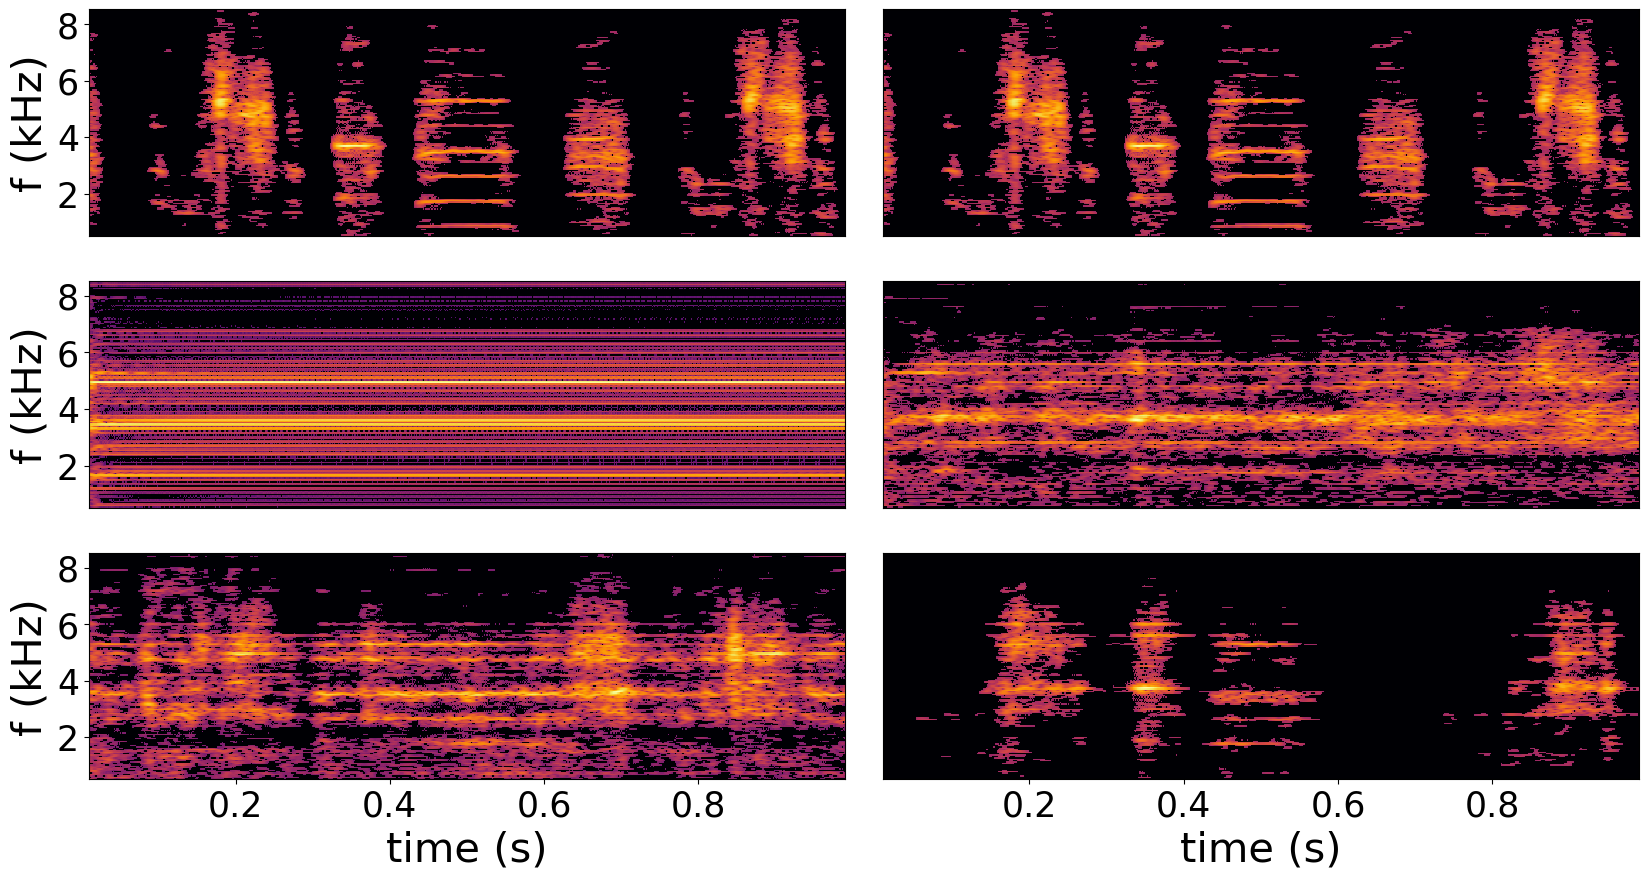

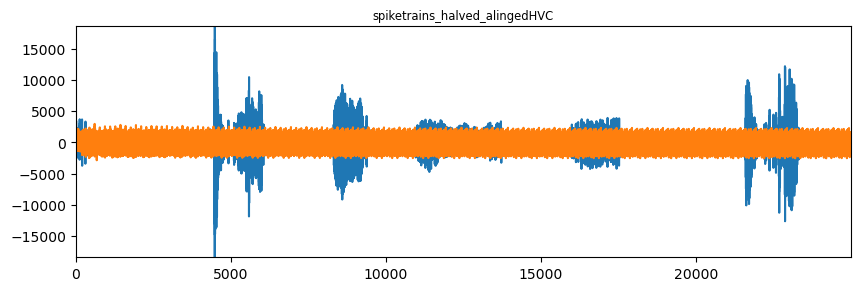

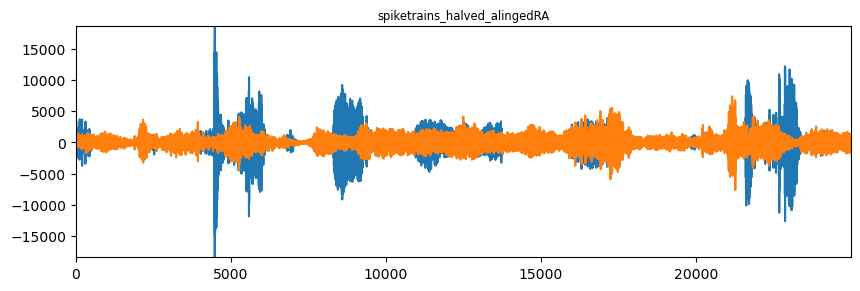

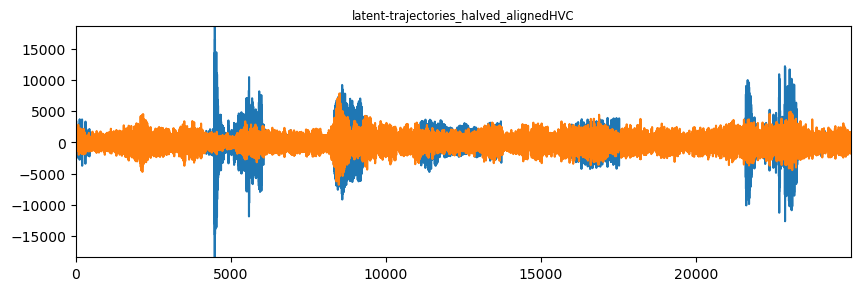

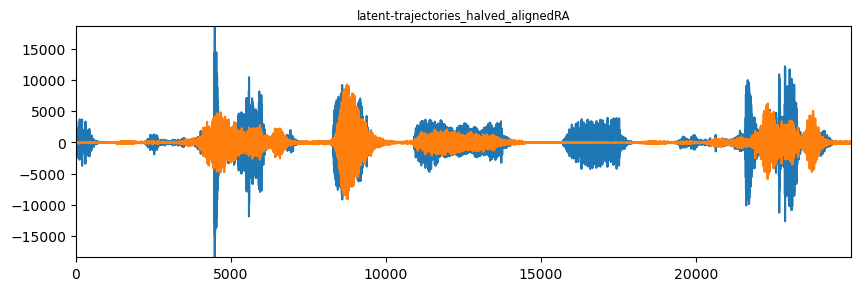

In [2]:
bird = 'z_w12m7_20'
models_dict = {
    'spiketrains_halved_alinged': {
        'HVC': '20240509_052938',
        'RA': '20240509_053009'
    },
    
    'latent-trajectories_halved_aligned': {
        'HVC': '20240509_053018',
        'RA': '20240509_053026'
    }
}


# Dirs
models_checkpoints_dir = '/home/jovyan/pablo_tostado/bird_song/enSongDec/ensongdec/models_checkpoints/'
dataset_dir = '/home/jovyan/pablo_tostado/bird_song/enSongDec/data/'

column_names = ['model_name', 'nucleus', 'model', 'Spectrogram reconstruction error']
decoding_accuracy_df5 = pd.DataFrame(columns=column_names)

# Plotting setup
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(20, 10))
plt.subplots_adjust(wspace=0.05)

# Processing each model type and nucleus
for col, model_type in enumerate(models_dict):
    for row, nucleus in enumerate(models_dict[model_type]):

        if models_dict[model_type][nucleus]:
            print(model_type, nucleus)
    
            # Load model
            model_timestamp = models_dict[model_type][nucleus]
            model_extension = '.pt'  
            model_files = [file for file in os.listdir(models_checkpoints_dir) if file.endswith(model_extension)]
            model_filename = next((file for file in model_files if model_timestamp in file), None)
    
            print('Loading model: ', model_filename)
            ffnn_model, test_dataset, test_loader, fs_audio, encodec_model, scales = load_model_statedict_align_complimentary_space(models_checkpoints_dir, dataset_dir, model_filename)
    
            # Reconstruct spectrogram
            scale = torch.mean(scales)
            original_audio, decoded_audio = get_original_reconstructed_audio(ffnn_model, test_dataset, test_loader, fs_audio, encodec_model, scale)
            
            print(original_audio.shape, decoded_audio.shape)
    
            # Calculate spectrogram reconstruction error
            s1 = su.normalize_signal(au.pretty_spectrogram(original_audio))
            s2 = su.normalize_signal(au.pretty_spectrogram(decoded_audio))
            spec_reconstruction_error = mean_squared_error(s1, s2, multioutput='raw_values')
            
            decoding_accuracy_df5.loc[len(decoding_accuracy_df5)] = [model_filename, nucleus, model_type, spec_reconstruction_error]
    
            # Plot original and reconstructed
            plot_s = 1
            plot_samples = int(plot_s*fs_audio)
            
            plt.subplots(nrows=1, figsize=(10, 3))
            plt.title(model_type + nucleus)
            plt.plot(original_audio[:plot_samples])
            plt.plot(decoded_audio[:plot_samples])
            
            xlabel = True if row == 1 else False
            # ylabel = True if col == 0 else False
            # plot_spectrogram(original_audio, fs_audio, plot_samples, ax=axes[row+1, col], xlabel=xlabel)
            plot_spectrogram(decoded_audio, fs_audio, plot_samples, ax=axes[row+1, col], xlabel=xlabel)

# Top row: repeat the plot of the original spectrograms in both columns
plot_spectrogram(original_audio, fs_audio, plot_samples, ax=axes[0, 0], xlabel=False, ylabel=True)
plot_spectrogram(original_audio, fs_audio, plot_samples, ax=axes[0, 1], xlabel=False, ylabel=False)
axes[1,1].set_ylabel(''), axes[1,1].set_yticks([])
axes[2,1].set_ylabel(''), axes[2,1].set_yticks([])

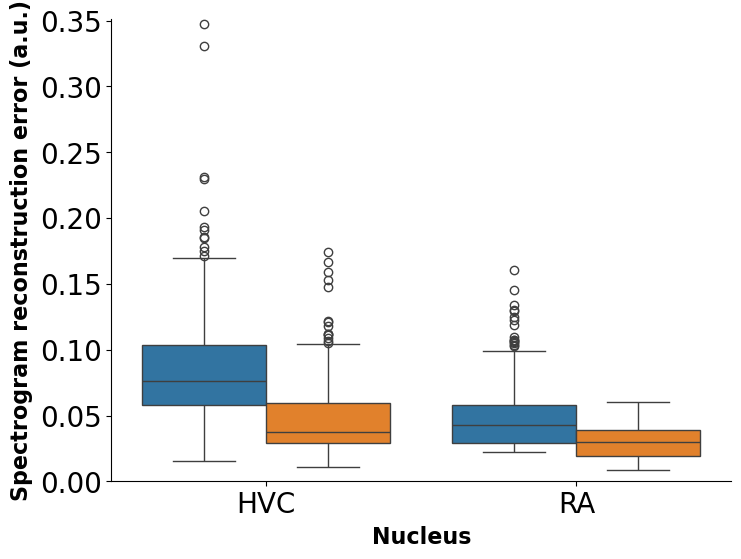

In [49]:
# Create separate rows for each value in the 'error' list
error_type = 'Spectrogram reconstruction error'
df_expanded = decoding_accuracy_df5.explode(error_type)
df_expanded[error_type] = pd.to_numeric(df_expanded[error_type])

# Create a box and whisker plot
fig, ax = plt.subplots(figsize=(8, 6))
sns.boxplot(x='nucleus', y=error_type, hue='model', data=df_expanded, notch=False)

plt.xlabel('Nucleus', fontsize=16, fontweight='bold')
plt.ylabel(error_type+' (a.u.)', fontsize=16, fontweight='bold')

# Remove top and right spines
ax.set_ylim([0, 0.351])
# ax.set_xlim([-0.5, len(significance) - 0.5])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.tick_params(axis='both', which='major', labelsize=20)  # Adjust 'labelsize' as needed
plt.legend(fontsize='16', loc=(0,1.1)) 
ax.get_legend().remove()

plt.show()

In [ ]:
warnings.filterwarnings("ignore")

bird = 'z_r12r13_21'
models_dict = {
    'spiketrains_halved_alinged': {
        'HVC': '20240509_051853',
        'RA': '20240509_051849'
    },
    
    'latent-trajectories_halved_aligned': {
        'HVC': '20240508_230047',
        'RA': '20240503_000101'
    }
}


# Dirs
models_checkpoints_dir = '/home/jovyan/pablo_tostado/bird_song/enSongDec/ensongdec/models_checkpoints/'
dataset_dir = '/home/jovyan/pablo_tostado/bird_song/enSongDec/data/'

column_names = ['model_name', 'nucleus', 'model', 'Spectrogram reconstruction error']
decoding_accuracy_df6 = pd.DataFrame(columns=column_names)

# Plotting setup
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(20, 10))
plt.subplots_adjust(wspace=0.05)

# Processing each model type and nucleus
for col, model_type in enumerate(models_dict):
    for row, nucleus in enumerate(models_dict[model_type]):

        if models_dict[model_type][nucleus]:
            print(model_type, nucleus)
    
            # Load model
            model_timestamp = models_dict[model_type][nucleus]
            model_extension = '.pt'  
            model_files = [file for file in os.listdir(models_checkpoints_dir) if file.endswith(model_extension)]
            model_filename = next((file for file in model_files if model_timestamp in file), None)
    
            print('Loading model: ', model_filename)
            ffnn_model, test_dataset, test_loader, fs_audio, encodec_model, scales = load_model_statedict_align_complimentary_space(models_checkpoints_dir, dataset_dir, model_filename)
    
            # Reconstruct spectrogram
            scale = torch.mean(scales)
            original_audio, decoded_audio = get_original_reconstructed_audio(ffnn_model, test_dataset, test_loader, fs_audio, encodec_model, scale)
            
            print(original_audio.shape, decoded_audio.shape)
    
            # Calculate spectrogram reconstruction error
            s1 = su.normalize_signal(au.pretty_spectrogram(original_audio))
            s2 = su.normalize_signal(au.pretty_spectrogram(decoded_audio))
            spec_reconstruction_error = mean_squared_error(s1, s2, multioutput='raw_values')
            
            decoding_accuracy_df6.loc[len(decoding_accuracy_df6)] = [model_filename, nucleus, model_type, spec_reconstruction_error]
    
            # Plot original and reconstructed
            plot_s = 1
            plot_samples = int(plot_s*fs_audio)
            
            plt.subplots(nrows=1, figsize=(10, 3))
            plt.title(model_type + nucleus)
            plt.plot(original_audio[:plot_samples])
            plt.plot(decoded_audio[:plot_samples])
            
            xlabel = True if row == 1 else False
            # ylabel = True if col == 0 else False
            # plot_spectrogram(original_audio, fs_audio, plot_samples, ax=axes[row+1, col], xlabel=xlabel)
            plot_spectrogram(decoded_audio, fs_audio, plot_samples, ax=axes[row+1, col], xlabel=xlabel)

# Top row: repeat the plot of the original spectrograms in both columns
plot_spectrogram(original_audio, fs_audio, plot_samples, ax=axes[0, 0], xlabel=False, ylabel=True)
plot_spectrogram(original_audio, fs_audio, plot_samples, ax=axes[0, 1], xlabel=False, ylabel=False)
axes[1,1].set_ylabel(''), axes[1,1].set_yticks([])
axes[2,1].set_ylabel(''), axes[2,1].set_yticks([])

spiketrains_halved_alinged HVC
Loading model:  RAW_z_r12r13_21_20240503_024021_hvc_all_latent_stability_dataset_FFNN_20240509_051853.pt
Loading RAW_z_r12r13_21_20240503_024021_hvc_all_latent_stability_dataset_FFNN_20240509_051853_metadata.json
Loaded model: train_idxs:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36]  - test_ixs:  [37, 38, 39, 40, 41, 42, 43, 44, 45, 46]  - model_layers:  [75, 64, 64, 128]
Length of neural trials: 899.9666666666667 ms, length of audio trials: 899.96 ms. 
Fitting CCA model to align neural spaces.
n_dims:  25
(986953, 25) (986953, 25)
fitting CCA model
CCA fitted!
Length of neural trials: 899.9666666666667 ms, length of audio trials: 899.96 ms. 
Using 3 bins of neural data history.
Data loaders created. Training samples: 4810, Testing sample: 1320
(220000,) (220000,)
spiketrains_halved_alinged RA
Loading model:  RAW_z_r12r13_21_20240502_201857_ra_all_latent_stabili

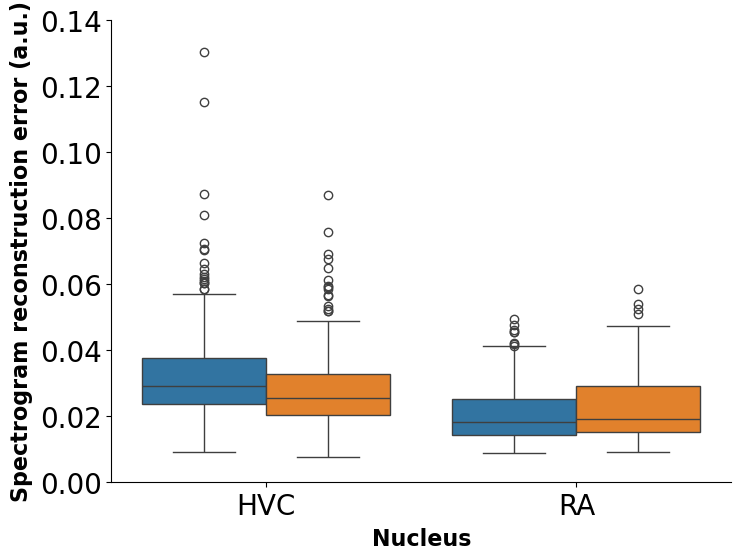

In [48]:
# Create separate rows for each value in the 'error' list
error_type = 'Spectrogram reconstruction error'
df_expanded = decoding_accuracy_df6.explode(error_type)
df_expanded[error_type] = pd.to_numeric(df_expanded[error_type])

# Create a box and whisker plot
fig, ax = plt.subplots(figsize=(8, 6))
sns.boxplot(x='nucleus', y=error_type, hue='model', data=df_expanded, notch=False)

plt.xlabel('Nucleus', fontsize=16, fontweight='bold')
plt.ylabel(error_type+' (a.u.)', fontsize=16, fontweight='bold')

# Remove top and right spines
ax.set_ylim([0, 0.14])
# ax.set_xlim([-0.5, len(significance) - 0.5])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.tick_params(axis='both', which='major', labelsize=20)  # Adjust 'labelsize' as needed
plt.legend(fontsize='16', loc=(0,1.1)) 
ax.get_legend().remove()

plt.show()